## 任务 5：大模型能力评估（40分）

### 作业要求

从开源和闭源两类大模型中，每一类至少选择 2 个模型、每个模型至少选择 2 个版本，参考文献中给出的评价指标，评估不同的大模型求解简单数学问题的能力。进一步，通过尝试优化提示、改进模型 CoT 推理过程等方法，提升大模型的性能。

### 参考数据

[GSM8K](https://huggingface.co/datasets/openai/gsm8k)

### 要求

撰写 5 页以内的评测报告，至少包含使用的模型及其特点、优化后的 Prompt、模型性能对比与分析等。

### 参考文献
 - [Karl Cobbe, et, at. Training Verifiers to Solve Math Word Problems. 2021.](https://arxiv.org/abs/2110.14168) 

---
---

# 实验报告

## 环境

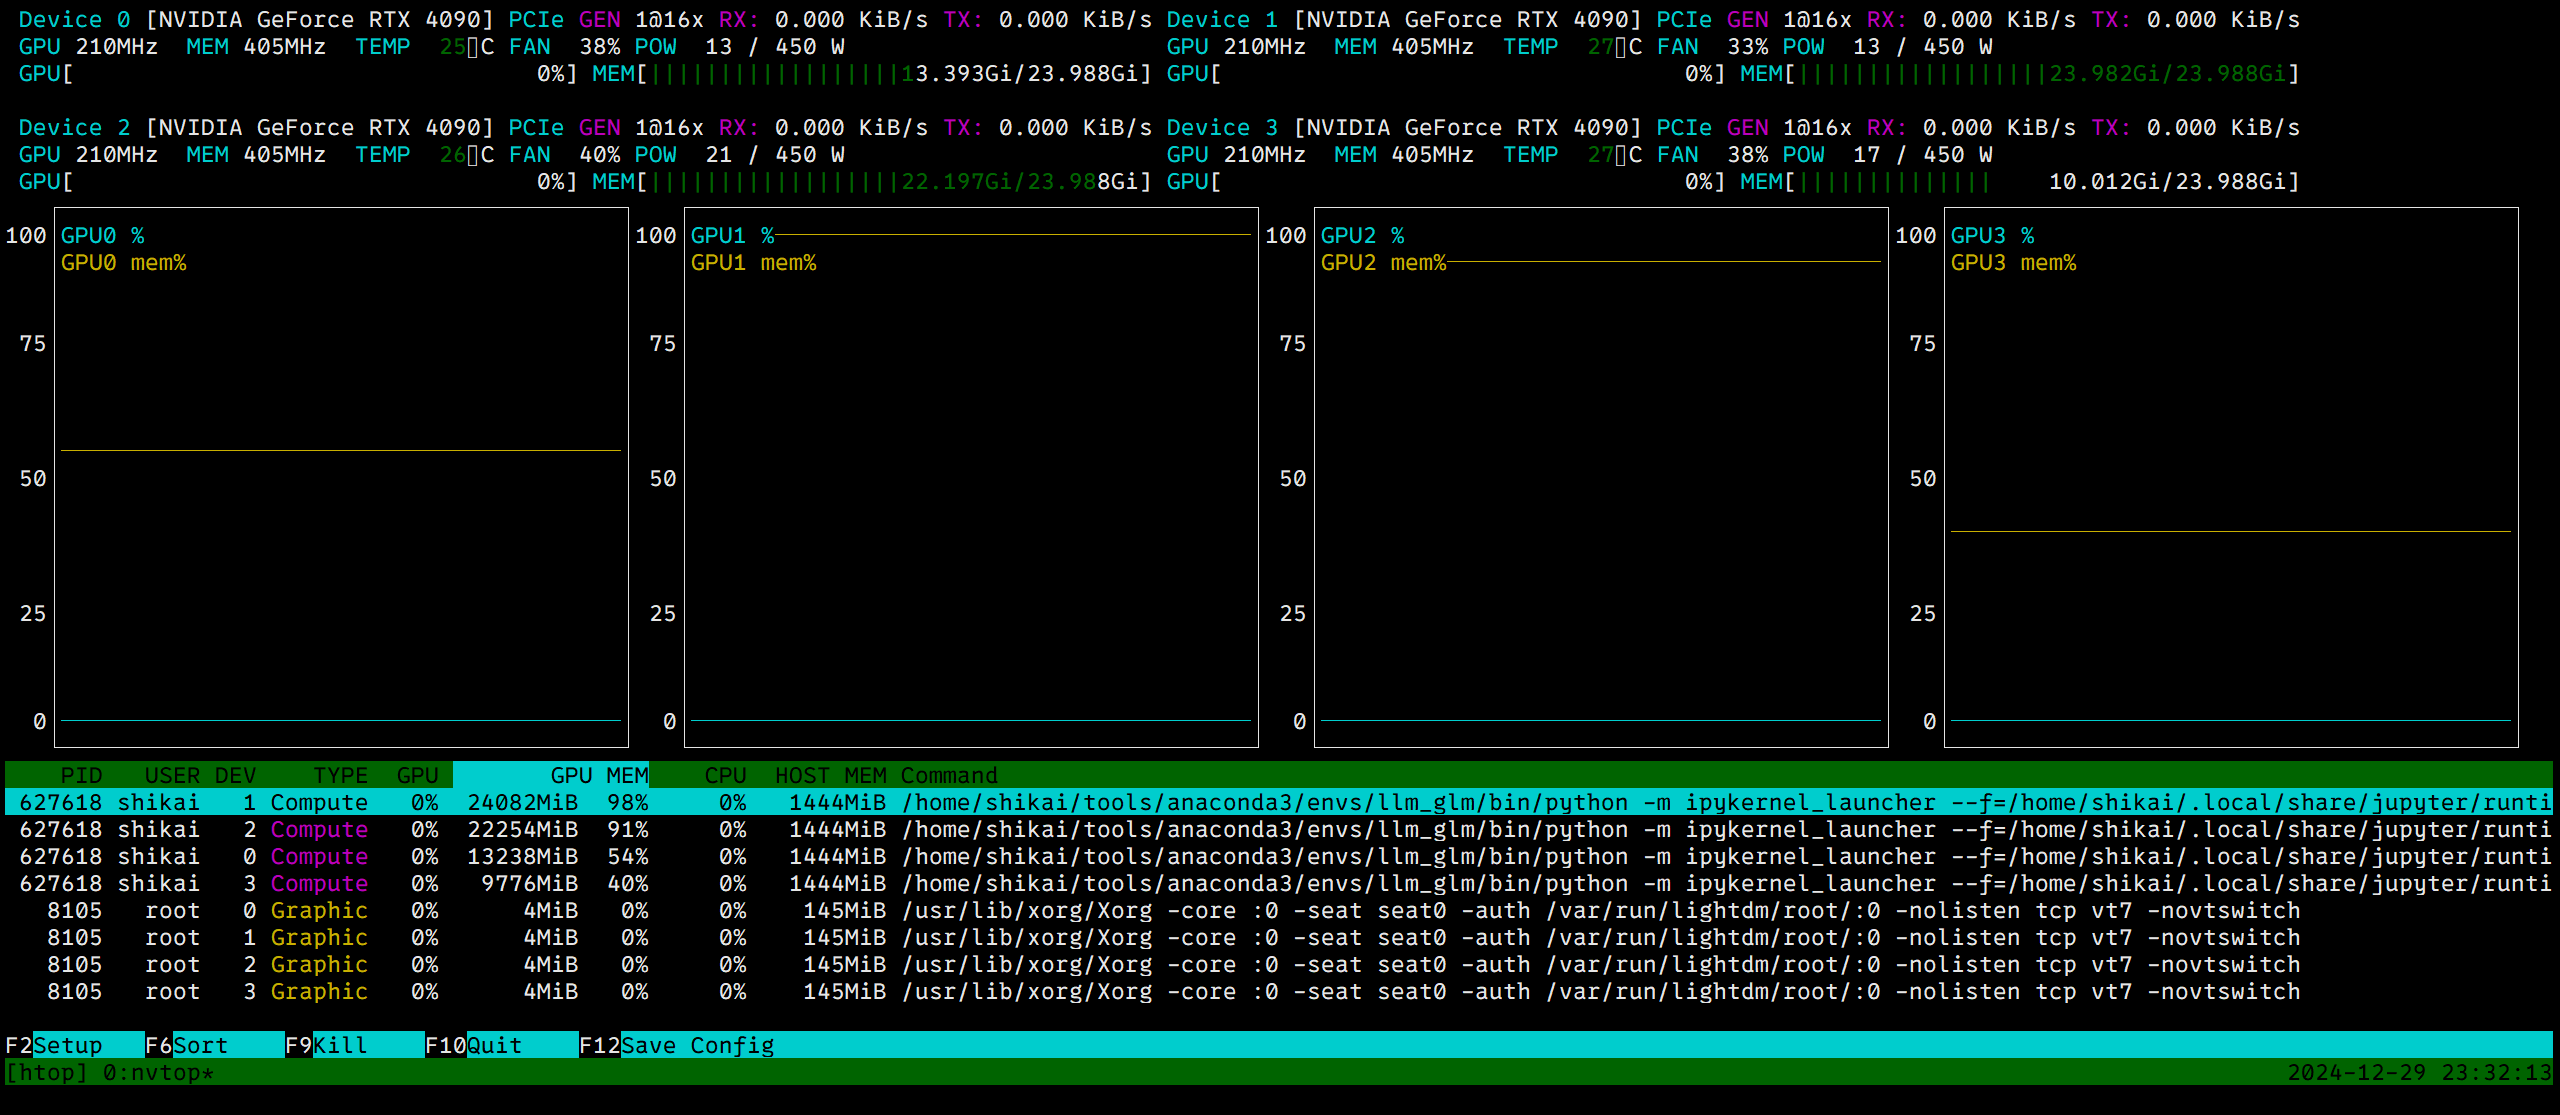




---
---

## 源码 👇
 - 开源模型
   - [ChatGLM2-6B](https://github.com/THUDM/ChatGLM2-6B)
     - [ChatGLM2-6B-hf](https://huggingface.co/THUDM/chatglm2-6b)
     - [ChatGLM4-9B-hf](https://huggingface.co/THUDM/glm-4-9b-chat-hf)
   - [LLAMA-2](https://huggingface.co/meta-llama)
     - [LLAMA-2-7B-Chat-hf](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf)
     - [LLAMA-2-13B-Chat-hf](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)

 - 闭源模型
   - GPT
     - GPT-3.5-turbo
     - GPT-4o-mini
   - o1
     - o1-mini
     - o1-preview


其中，OpenAI 的 GPT 计价如下：

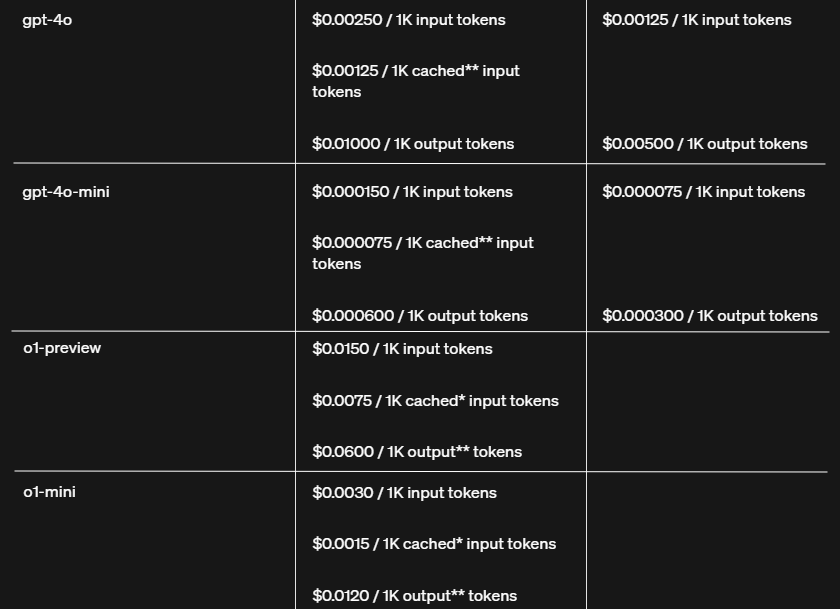


老师，做这些实验的费用可以报销么.. 

[注]

- LLAMA 的模型需要申请 [Meta 的许可证](https://ai.meta.com/resources/models-and-libraries/llama-downloads/) 才能下载。

---

In [1]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, GPTNeoXForCausalLM, GPT2Tokenizer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from datasets import Dataset

In [2]:
# init logger
import logging, sys, codecs

logger = logging.getLogger()
logger.setLevel(logging.INFO)

def set_log_file(filename:str):
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

    handler = logging.FileHandler(filename, encoding='utf-8', mode='w')
    formatter = logging.Formatter('[%(asctime)s][%(levelname)s] %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
gsm8k_test_path = "../data/gsm8k/test-00000-of-00001.parquet"
gsm8k_train_path = "../data/gsm8k/train-00000-of-00001.parquet"

ds_test = Dataset.from_parquet(gsm8k_test_path)
ds_train = Dataset.from_parquet(gsm8k_train_path)

print(f"Train Dataset Sample: {ds_train[0]}")
print(f"Test Dataset Sample: {ds_test[0]}")

Train Dataset Sample: {'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}
Test Dataset Sample: {'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?", 'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18'}


---

## 开源模型 2.1 ChatGLM2-6B

### 模型实现和权重

由于本地连接 Huggingface 的网络环境不佳，故模型实现和权重均为本地加载。

- **[注意] 本模型需降级 transformers 模块:**

 ```bash
 pip uninstall transformers -y
 pip install transformers==4.41.2
 ```

后续实验中，再将 transformers 升级至最新版本。

```bash
pip uninstall transformers -y
pip install transformers
```

In [5]:
MODEL_PATH = "../data/chatglm2-6b"

if device.startswith("cuda"):
    device_glm2_6b = "cuda:2"

print(f"Using device: {device_glm2_6b} for ChatGLM2-6B.")

tokenizer_glm2_6b = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)
model_glm2_6b = AutoModel.from_pretrained(MODEL_PATH, trust_remote_code=True, device=device_glm2_6b)
model_glm2_6b = model_glm2_6b.eval()

Using device: cuda:2 for ChatGLM2-6B.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
def infer_with_glm2_6b(question, history=[]):
    response, _history = model_glm2_6b.chat(tokenizer_glm2_6b, question, history=[])
    return response, _history

---

## 开源模型 2.2 ChatGLM4-9B

- **[ATTENTION]**
    - 推理 `ChatGLM4-9B`前，需要升级 Transformers 到 `>= 4.46.0` 版本，否则会出现错误。
    - `Python` == `3.10.12`

参考资料：
 - [[FIXED] Exception: data did not match any variant of untagged enum ModelWrapper at line 1251003 column 3](https://github.com/unslothai/unsloth/issues/1059)


In [8]:
MODEL_PATH = "../data/glm-4-9b-chat-hf"

if device.startswith("cuda"):
    device_glm4_9b_hf = "cuda:3"
    
print(f"Using device: {device_glm4_9b_hf} for ChatGLM4-9B.")

tokenizer_glm4_9b = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_PATH, trust_remote_code=True)
model_glm4_9b = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map='auto'
).eval()

Using device: cuda:3 for ChatGLM4-9B.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
def infer_with_glm4_9b(question):
    message = [
        {
            "role": "system",
            "content": "Answer the following question. At the end of you answer, include 'The answer: xxx.', xxx is a number. "
        },
        {
            "role": "user",
            "content": question
        }
    ]
    inputs = tokenizer_glm4_9b.apply_chat_template(message,
                                       add_generation_prompt=True,
                                       tokenize=True,
                                       return_tensors="pt",
                                       return_dict=True
                                       )
    try:    
        inputs['input_ids'] = inputs['input_ids'].to('cuda')
        inputs['attention_mask'] = inputs['attention_mask'].to('cuda')
    except:
        pass
           
    with torch.no_grad():
        outputs = model_glm4_9b.generate(input_ids=inputs['input_ids'],
                                            attention_mask=inputs['attention_mask'],
                                            max_length=4096,
                                            do_sample=True,
                                            top_k=1)
        outputs = outputs[:, inputs['input_ids'].shape[1]:]
        return tokenizer_glm4_9b.decode(outputs[0], skip_special_tokens=True)

---

## 开源模型 1.1：LLAMA-2-7b-Chat

In [5]:
from transformers import LlamaForCausalLM, LlamaTokenizer
import torch

MODEL_PATH = "../data/Llama-2-7b-chat-hf"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device} for LLAMA-2-7b.")

model_llama_2_7b_chat = LlamaForCausalLM.from_pretrained(MODEL_PATH, torch_dtype=torch.float16).to(device)
tokenizer_llama_2_7b_chat = LlamaTokenizer.from_pretrained(MODEL_PATH)

Using device: cuda:0 for LLAMA-2-7b.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
def infer_with_llama_2_7b_chat(prompt: str) -> str:
    system_prompt = (
        '''You are a helpful assistant. After the analysis, append a new line behind you analysis: 'The answer: xxx.', where xxx is final numberic answer of your analysis, without any pre or post units.'''
    )
    full_prompt = f'''<<SYS>>{system_prompt}\n<</SYS>>\n[INST]{prompt}[/INST]\n'''
    
    inputs = tokenizer_llama_2_7b_chat(full_prompt, return_tensors='pt').to(device)
    output = model_llama_2_7b_chat.generate(
        input_ids=inputs['input_ids'], 
        attention_mask=inputs.get('attention_mask'),
        max_length=4096,
        do_sample=True,
        repetition_penalty=1.2,
        temperature=0.7
    )
    generated_text = tokenizer_llama_2_7b_chat.decode(output[0], skip_special_tokens=True)
    return generated_text

---

## 开源模型 1.2：LLAMA-2-13B-Chat

In [5]:
from transformers import LlamaConfig,LlamaForCausalLM,LlamaTokenizer
from accelerate import init_empty_weights,infer_auto_device_map
import torch


no_split_module_classes = LlamaForCausalLM._no_split_modules

cuda_list = '1,2'.split(',')
memory = '20GiB'
max_memory = {int(cuda):memory for cuda in cuda_list}

MODEL_PATH = "../data/Llama-2-13b-chat-hf"
tokenizer_llama_2_13b_chat = LlamaTokenizer.from_pretrained(MODEL_PATH)

config = LlamaConfig.from_pretrained(MODEL_PATH)
with init_empty_weights():
    model_llama_2_13b_chat = LlamaForCausalLM._from_config(config, torch_dtype=torch.float16)

device_map = infer_auto_device_map(model_llama_2_13b_chat, max_memory=max_memory,no_split_module_classes=no_split_module_classes)

model_llama_2_13b_chat = LlamaForCausalLM.from_pretrained(MODEL_PATH, device_map=device_map, torch_dtype=torch.float16)

print(f"Using device: {device_map} for LLAMA-2-13b-Chat.")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using device: OrderedDict([('model.embed_tokens', 1), ('model.layers.0', 1), ('model.layers.1', 1), ('model.layers.2', 1), ('model.layers.3', 1), ('model.layers.4', 1), ('model.layers.5', 1), ('model.layers.6', 1), ('model.layers.7', 1), ('model.layers.8', 1), ('model.layers.9', 1), ('model.layers.10', 1), ('model.layers.11', 1), ('model.layers.12', 1), ('model.layers.13', 1), ('model.layers.14', 1), ('model.layers.15', 1), ('model.layers.16', 1), ('model.layers.17', 1), ('model.layers.18', 1), ('model.layers.19', 1), ('model.layers.20', 1), ('model.layers.21', 1), ('model.layers.22', 1), ('model.layers.23', 1), ('model.layers.24', 1), ('model.layers.25', 1), ('model.layers.26', 1), ('model.layers.27', 1), ('model.layers.28', 1), ('model.layers.29', 1), ('model.layers.30', 1), ('model.layers.31', 1), ('model.layers.32', 2), ('model.layers.33', 2), ('model.layers.34', 2), ('model.layers.35', 2), ('model.layers.36', 2), ('model.layers.37', 2), ('model.layers.38', 2), ('model.layers.39', 

In [6]:
def infer_with_llama_2_13b_chat(prompt: str) -> str:
    system_prompt = (
        '''You are a helpful assistant. After the analysis, append a new line behind you analysis: 'The answer: xxx.', where xxx is final numberic answer of your analysis, without any pre or post units.'''
    )
    full_prompt = f'''<<SYS>>{system_prompt}\n<</SYS>>\n[INST]{prompt}[/INST]\n'''
    
    
    inputs = tokenizer_llama_2_13b_chat(full_prompt, return_tensors='pt').to(device)
    output = model_llama_2_13b_chat.generate(input_ids=inputs['input_ids'], 
                                              attention_mask=inputs.get('attention_mask'),
                                              max_length=4096,
                                              do_sample=True,
                                              repetition_penalty=1.2,
                                              temperature=0.7)
    generated_text = tokenizer_llama_2_13b_chat.decode(output[0], skip_special_tokens=True)
    return generated_text

---

## 闭源模型 1.1 GPT4o
## 闭源模型 1.2 GPT4o-mini
## 闭源模型 2.1 o1-mini
## 闭源模型 2.2 o1-preview

### 可用的模型 👇

我的 OpenAI API 目前可用的模型有：

 - `gpt-4o-audio-preview-2024-10-01`
 - `gpt-4o-realtime-preview`
 - `gpt-4o-realtime-preview-2024-10-01`
 - `o1-mini-2024-09-12`
 - `dall-e-2`
 - `gpt-4-turbo`
 - `gpt-4-1106-preview`
 - `gpt-3.5-turbo`
 - `gpt-3.5-turbo-0125`
 - `gpt-3.5-turbo-instruct`
 - `babbage-002`
 - `whisper-1`
 - `dall-e-3`
 - `text-embedding-3-small`
 - `gpt-3.5-turbo-16k`
 - `gpt-4-0125-preview`
 - `gpt-4-turbo-preview`
 - `omni-moderation-latest`
 - `gpt-4o-2024-05-13`
 - `omni-moderation-2024-09-26`
 - `tts-1-hd-1106`
 - `chatgpt-4o-latest`
 - `gpt-4`
 - `gpt-4-0613`
 - `o1-mini`
 - `o1-preview`
 - `o1-preview-2024-09-12`
 - `tts-1-hd`
 - `text-embedding-ada-002`
 - `gpt-3.5-turbo-1106`
 - `gpt-4o-audio-preview`
 - `tts-1`
 - `tts-1-1106`
 - `gpt-3.5-turbo-instruct-0914`
 - `davinci-002`
 - `text-embedding-3-large`
 - `gpt-4o-realtime-preview-2024-12-17`
 - `gpt-4o-mini-realtime-preview`
 - `gpt-4o-mini-realtime-preview-2024-12-17`
 - `gpt-4o-2024-08-06`
 - `gpt-4o`
 - `gpt-4o-mini`
 - `gpt-4o-mini-2024-07-18`
 - `gpt-4o-2024-11-20`
 - `gpt-4o-audio-preview-2024-12-17`
 - `gpt-4o-mini-audio-preview`
 - `gpt-4o-mini-audio-preview-2024-12-17`
 - `gpt-4-turbo-2024-04-09`


In [5]:
import openai

OPENAI_API_KEY = "sk-HHHHH"

from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)
print(client.models.list())

def infer_with_gpt(prompt, model="gpt-3.5-turbo"):
    if model not in ["gpt-3.5-turbo", "gpt-4o-mini", "o1-mini", "o1-preview"]:
        raise ValueError("model must be either 'gpt-3.5-turbo' or 'gpt-4o-mini' or 'o1-mini' or 'o1-preview'")
    
    message = [
            {
                
                "role": "system",
                "content": "Answer the following question and do not use markdown, reply in plaintext. At the end of you answer, include 'The answer: xxx.', xxx is a number. "
            },
            {
                "role": "user",
                "content": f"{prompt}"
            }
        ]
    if model == 'o1-mini' or model == 'o1-preview':
        message[0]["role"] = "assistant"
    else:
        message[0]["role"] = "system"
    
    logger.info(f"[Question]: {message}")
    
    completion = client.chat.completions.create(
        model=model,
        messages=message
    )
    output = None
    try:
        output = completion.choices[0].message.content
        logger.info(f"[tokens]: {completion.usage.completion_tokens}")
    except:
        pass
    return output  

SyncPage[Model](data=[Model(id='gpt-4o-audio-preview-2024-10-01', created=1727389042, object='model', owned_by='system'), Model(id='gpt-4o-realtime-preview', created=1727659998, object='model', owned_by='system'), Model(id='gpt-4o-realtime-preview-2024-10-01', created=1727131766, object='model', owned_by='system'), Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'), Model(id='gpt-4-turbo', created=1712361441, object='model', owned_by='system'), Model(id='gpt-4-1106-preview', created=1698957206, object='model', owned_by='system'), Model(id='gpt-3.5-turbo', created=1677610602, object='model', owned_by='openai'), Model(id='gpt-3.5-turbo-0125', created=1706048358, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-instruct', created=1692901427, object='model', owned_by='system'), Model(id='babbage-002', created=1692634615, object='model', owned_by='system'), Model(id='gpt-4o-mini-2024-07-18', created=1721172717, object='model', owned_by='system'), Model(id

---

## LLM 评价

这部分将基于 `GSM8K` Math Solving 数据集，对上述的 8 个模型进行评价。

这里根据参考文献中的 `CoT` 推理方法进行实验，评估这些模型在 1396 个测试样本上的结果正确性。

In [7]:
import re

TRUE = 0
FALSE = 1
ERROR = 2

def reFind(text:str):
    pattern = r'The answer:\s*[$]?([\d,]+(?:\.\d+)?)'
    match = re.search(pattern, text)
    number = None
    if match:
        number_str = match.group(1)
        number_str = number_str.replace(',', '')
        return float(number_str) if '.' in number_str else int(number_str)
    return number

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def judge(truth:str, answer:str) -> int:
    """_summary_
        extract the numbers from the answer.
        
        e.g. Truth: "Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day. \nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18"
        
        e.g. Answer: "First find how many eggs Janet eats each day: 16 eggs / day - 3 eggs / day = 13 eggs / day. Then find how many eggs she bakes each day: 13 eggs / day * 4 eggs / day = 52 eggs / day. Then find the total number of eggs she sells each day: 52 eggs / day - 13 eggs / day = 39 eggs / day. Then multiply the number of eggs she sells by the price per egg to find her total earnings: 39 eggs / day * $2 / egg = $78 / day.\nThe answer: 78."
        
        In Truth, the number '18' after the last '####' is the final answer.
        In Answer, the number '78' after the last 'The answer: ' is the final answer.
    """
    logging.info(f"[Judge] [Truth]: {truth}")
    logging.info(f"[Judge] [Answer]: {answer}")
    success = 0
    try:
        truth_num = truth.split('####')[-1].strip()
        answer_num = reFind(answer)
        if answer_num is None:
            return ERROR
        if is_number(truth_num) and is_number(answer_num):
            if float(truth_num) == float(answer_num):
                success = TRUE
            else:
                success = FALSE
        
        logging.info(f"[Judge] {success}. Truth: {truth_num}, Answer: {answer_num}")
    except Exception as e:
        success = FALSE
        logging.info(f"[Judge] Skip this question for patten dismatch: {e}")
    finally:
        return success

In [8]:

# CoT 推理提示生成函数
def generate_cot_prompt(problem):
    return f"Let's solve this problem step by step: {problem}"

# 评价函数
def evaluate_accuracy(model:str, dataset, cot_prompt=False):
    if cot_prompt:
        set_log_file(f"evaluate_{model}.log")
    else:
        set_log_file(f"evaluate_{model}_no_cot.log")
    
    correct_count = 0
    current_count = 0
    
    DATA_LEN = 100
    
    dataset_new = dataset.select(range(DATA_LEN))
    
    total_count = len(dataset_new)
    
    MAX_TRIAL = 100
        
    accuracy = 0 
        
    for example in dataset_new:
        MAX_TRIAL -= 1
        if MAX_TRIAL <= 0 or len(dataset_new) == len(dataset):
            break
        question = example["question"]
        truth = example["answer"]
        
        if cot_prompt:
            prompt = generate_cot_prompt(question)
        else:
            prompt = question
        
        if model == "gpt-3.5-turbo":
            model_result = infer_with_gpt(prompt, model="gpt-3.5-turbo")
        elif model == "gpt-4o-mini":
            model_result = infer_with_gpt(prompt, model="gpt-4o-mini")
        elif model == "o1-mini":
            model_result = infer_with_gpt(prompt, model="o1-mini")
        elif model == "o1-preview":
            model_result = infer_with_gpt(prompt, model="o1-preview")
        elif model == "glm2-6b":
            model_result, _ = infer_with_glm2_6b(prompt)
        elif model == "glm4_9b":
            model_result = infer_with_glm4_9b(prompt)
        elif model == "llama_2_7b_chat":
            model_result = infer_with_llama_2_7b_chat(prompt)
        elif model == "llama_2_13b_chat":
            model_result = infer_with_llama_2_13b_chat(prompt)
        else:
            print(f"Model '{model}' is not supported.")
            return
        
        res = judge(truth, model_result)
        if res == ERROR:
            MAX_TRIAL += 1
            dataset_new = dataset.select(range(DATA_LEN+1))
            continue
        elif res == TRUE:
            current_count += 1
            correct_count += 1
        else:
            current_count += 1

        accuracy = correct_count/current_count
        print(f"[Evaluate] Accuracy[{current_count}/{total_count}] = {accuracy* 100:.2f}%")
        
    return accuracy

## COT-Prompt-OFF ❌

In [9]:
glm2_6b_accuracy = evaluate_accuracy("glm2-6b", dataset=ds_test, cot_prompt=False)
print(f"ChatGLM2-6B-with-COT-Off Accuracy: {glm2_6b_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 100.00%
[Evaluate] Accuracy[4/100] = 100.00%
[Evaluate] Accuracy[5/100] = 100.00%
[Evaluate] Accuracy[6/100] = 100.00%
[Evaluate] Accuracy[7/100] = 100.00%
[Evaluate] Accuracy[8/100] = 100.00%
[Evaluate] Accuracy[9/100] = 100.00%
[Evaluate] Accuracy[10/100] = 100.00%
[Evaluate] Accuracy[11/100] = 100.00%
[Evaluate] Accuracy[12/100] = 100.00%
[Evaluate] Accuracy[13/100] = 100.00%
[Evaluate] Accuracy[14/100] = 100.00%
[Evaluate] Accuracy[15/100] = 100.00%
[Evaluate] Accuracy[16/100] = 100.00%
[Evaluate] Accuracy[17/100] = 100.00%
[Evaluate] Accuracy[18/100] = 100.00%
[Evaluate] Accuracy[19/100] = 100.00%
[Evaluate] Accuracy[20/100] = 100.00%
[Evaluate] Accuracy[21/100] = 100.00%
[Evaluate] Accuracy[22/100] = 100.00%
[Evaluate] Accuracy[23/100] = 100.00%
[Evaluate] Accuracy[24/100] = 100.00%
[Evaluate] Accuracy[25/100] = 100.00%
[Evaluate] Accuracy[26/100] = 100.00%
[Evaluate] Accuracy[2

In [9]:
glm4_9b_hf_accuracy = evaluate_accuracy("glm4_9b", dataset=ds_test, cot_prompt=False)
print(f"GLM4-9B-with-COT-Off Accuracy: {glm4_9b_hf_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 100.00%
[Evaluate] Accuracy[4/100] = 100.00%
[Evaluate] Accuracy[5/100] = 80.00%
[Evaluate] Accuracy[6/100] = 83.33%
[Evaluate] Accuracy[7/100] = 71.43%
[Evaluate] Accuracy[8/100] = 62.50%
[Evaluate] Accuracy[9/100] = 55.56%
[Evaluate] Accuracy[10/100] = 60.00%
[Evaluate] Accuracy[11/100] = 54.55%
[Evaluate] Accuracy[12/100] = 50.00%
[Evaluate] Accuracy[13/100] = 46.15%
[Evaluate] Accuracy[14/100] = 42.86%
[Evaluate] Accuracy[15/100] = 46.67%
[Evaluate] Accuracy[16/100] = 50.00%
[Evaluate] Accuracy[17/100] = 52.94%
[Evaluate] Accuracy[18/100] = 50.00%
[Evaluate] Accuracy[19/100] = 52.63%
[Evaluate] Accuracy[20/100] = 55.00%
[Evaluate] Accuracy[21/100] = 52.38%
[Evaluate] Accuracy[22/100] = 54.55%
[Evaluate] Accuracy[23/100] = 52.17%
[Evaluate] Accuracy[24/100] = 54.17%
[Evaluate] Accuracy[25/100] = 56.00%
[Evaluate] Accuracy[26/100] = 53.85%
[Evaluate] Accuracy[27/100] = 51.85%
[Evalu

In [9]:
llam_2_7b_chat_accuracy = evaluate_accuracy("llama_2_7b_chat", dataset=ds_test, cot_prompt=False)
print(f"LLAM-2-7b-Chat-with-COT-Off Accuracy: {llam_2_7b_chat_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 100.00%
[Evaluate] Accuracy[4/100] = 75.00%
[Evaluate] Accuracy[5/100] = 80.00%
[Evaluate] Accuracy[6/100] = 66.67%
[Evaluate] Accuracy[7/100] = 57.14%
[Evaluate] Accuracy[8/100] = 62.50%
[Evaluate] Accuracy[9/100] = 55.56%
[Evaluate] Accuracy[10/100] = 50.00%
[Evaluate] Accuracy[11/100] = 54.55%
[Evaluate] Accuracy[12/100] = 50.00%
[Evaluate] Accuracy[13/100] = 46.15%
[Evaluate] Accuracy[14/100] = 42.86%
[Evaluate] Accuracy[15/100] = 40.00%
[Evaluate] Accuracy[16/100] = 37.50%
[Evaluate] Accuracy[17/100] = 41.18%
[Evaluate] Accuracy[18/100] = 38.89%
[Evaluate] Accuracy[19/100] = 36.84%
[Evaluate] Accuracy[20/100] = 35.00%
[Evaluate] Accuracy[21/100] = 38.10%
[Evaluate] Accuracy[22/100] = 36.36%
[Evaluate] Accuracy[23/100] = 34.78%
[Evaluate] Accuracy[24/100] = 37.50%
[Evaluate] Accuracy[25/100] = 36.00%
[Evaluate] Accuracy[26/100] = 38.46%
[Evaluate] Accuracy[27/100] = 40.74%
[Evalua

In [9]:
llam_2_13b_chat_accuracy = evaluate_accuracy("llama_2_13b_chat", dataset=ds_test, cot_prompt=False)
print(f"LLAM-2-13b-Chat-with-COT-Off Accuracy: {llam_2_13b_chat_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 50.00%
[Evaluate] Accuracy[3/100] = 33.33%
[Evaluate] Accuracy[4/100] = 25.00%
[Evaluate] Accuracy[5/100] = 20.00%
[Evaluate] Accuracy[6/100] = 33.33%
[Evaluate] Accuracy[7/100] = 28.57%
[Evaluate] Accuracy[8/100] = 25.00%
[Evaluate] Accuracy[9/100] = 22.22%
[Evaluate] Accuracy[10/100] = 30.00%
[Evaluate] Accuracy[11/100] = 27.27%
[Evaluate] Accuracy[12/100] = 25.00%
[Evaluate] Accuracy[13/100] = 23.08%
[Evaluate] Accuracy[14/100] = 28.57%
[Evaluate] Accuracy[15/100] = 26.67%
[Evaluate] Accuracy[16/100] = 31.25%
[Evaluate] Accuracy[17/100] = 29.41%
[Evaluate] Accuracy[18/100] = 33.33%
[Evaluate] Accuracy[19/100] = 31.58%
[Evaluate] Accuracy[20/100] = 30.00%
[Evaluate] Accuracy[21/100] = 28.57%
[Evaluate] Accuracy[22/100] = 27.27%
[Evaluate] Accuracy[23/100] = 30.43%
[Evaluate] Accuracy[24/100] = 33.33%
[Evaluate] Accuracy[25/100] = 36.00%
[Evaluate] Accuracy[26/100] = 38.46%
[Evaluate] Accuracy[27/100] = 40.74%
[Evaluate

In [10]:
gpt_3_5_turbo_accuracy = evaluate_accuracy("gpt-3.5-turbo", dataset=ds_test, cot_prompt=False)
print(f"GPT-3.5-turbo-with-COT-Off Accuracy: {gpt_3_5_turbo_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 66.67%
[Evaluate] Accuracy[4/100] = 75.00%
[Evaluate] Accuracy[5/100] = 80.00%
[Evaluate] Accuracy[6/100] = 83.33%
[Evaluate] Accuracy[7/100] = 85.71%
[Evaluate] Accuracy[8/100] = 87.50%
[Evaluate] Accuracy[9/100] = 77.78%
[Evaluate] Accuracy[10/100] = 80.00%
[Evaluate] Accuracy[11/100] = 81.82%
[Evaluate] Accuracy[12/100] = 83.33%
[Evaluate] Accuracy[13/100] = 76.92%
[Evaluate] Accuracy[14/100] = 71.43%
[Evaluate] Accuracy[15/100] = 66.67%
[Evaluate] Accuracy[16/100] = 68.75%
[Evaluate] Accuracy[17/100] = 70.59%
[Evaluate] Accuracy[18/100] = 72.22%
[Evaluate] Accuracy[19/100] = 73.68%
[Evaluate] Accuracy[20/100] = 75.00%
[Evaluate] Accuracy[21/100] = 76.19%
[Evaluate] Accuracy[22/100] = 77.27%
[Evaluate] Accuracy[23/100] = 73.91%
[Evaluate] Accuracy[24/100] = 75.00%
[Evaluate] Accuracy[25/100] = 76.00%
[Evaluate] Accuracy[26/100] = 76.92%
[Evaluate] Accuracy[27/100] = 77.78%
[Evaluat

In [11]:
gpt_4o_mini_accuracy = evaluate_accuracy("gpt-4o-mini", dataset=ds_test, cot_prompt=False)
print(f"GPT-4o-mini-with-COT-Off Accuracy: {gpt_4o_mini_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 50.00%
[Evaluate] Accuracy[3/100] = 33.33%
[Evaluate] Accuracy[4/100] = 50.00%
[Evaluate] Accuracy[5/100] = 60.00%
[Evaluate] Accuracy[6/100] = 66.67%
[Evaluate] Accuracy[7/100] = 71.43%
[Evaluate] Accuracy[8/100] = 75.00%
[Evaluate] Accuracy[9/100] = 77.78%
[Evaluate] Accuracy[10/100] = 80.00%
[Evaluate] Accuracy[11/100] = 81.82%
[Evaluate] Accuracy[12/100] = 83.33%
[Evaluate] Accuracy[13/100] = 76.92%
[Evaluate] Accuracy[14/100] = 78.57%
[Evaluate] Accuracy[15/100] = 80.00%
[Evaluate] Accuracy[16/100] = 81.25%
[Evaluate] Accuracy[17/100] = 82.35%
[Evaluate] Accuracy[18/100] = 83.33%
[Evaluate] Accuracy[19/100] = 84.21%
[Evaluate] Accuracy[20/100] = 85.00%
[Evaluate] Accuracy[21/100] = 85.71%
[Evaluate] Accuracy[22/100] = 86.36%
[Evaluate] Accuracy[23/100] = 86.96%
[Evaluate] Accuracy[24/100] = 87.50%
[Evaluate] Accuracy[25/100] = 88.00%
[Evaluate] Accuracy[26/100] = 88.46%
[Evaluate] Accuracy[27/100] = 88.89%
[Evaluate

In [13]:
gpt_o1_mini_accuracy = evaluate_accuracy("o1-mini", dataset=ds_test, cot_prompt=False)
print(f"o1-mini-with-COT-Off Accuracy: {gpt_o1_mini_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 100.00%
[Evaluate] Accuracy[4/100] = 100.00%
[Evaluate] Accuracy[5/100] = 100.00%
[Evaluate] Accuracy[6/100] = 100.00%
[Evaluate] Accuracy[7/100] = 100.00%
[Evaluate] Accuracy[8/100] = 100.00%
[Evaluate] Accuracy[9/100] = 100.00%
[Evaluate] Accuracy[10/100] = 100.00%
[Evaluate] Accuracy[11/100] = 100.00%
[Evaluate] Accuracy[12/100] = 100.00%
[Evaluate] Accuracy[13/100] = 100.00%
[Evaluate] Accuracy[14/100] = 100.00%
[Evaluate] Accuracy[15/100] = 100.00%
[Evaluate] Accuracy[16/100] = 100.00%
[Evaluate] Accuracy[17/100] = 100.00%
[Evaluate] Accuracy[18/100] = 100.00%
[Evaluate] Accuracy[19/100] = 100.00%
[Evaluate] Accuracy[20/100] = 100.00%
[Evaluate] Accuracy[21/100] = 100.00%
[Evaluate] Accuracy[22/100] = 100.00%
[Evaluate] Accuracy[23/100] = 100.00%
[Evaluate] Accuracy[24/100] = 100.00%
[Evaluate] Accuracy[25/100] = 100.00%
[Evaluate] Accuracy[26/100] = 100.00%
[Evaluate] Accuracy[2

In [8]:
gpt_o1_preview_accuracy = evaluate_accuracy("o1-preview", dataset=ds_test, cot_prompt=False)
print(f"o1-preview-with-COT-Off Accuracy: {gpt_o1_preview_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/20] = 100.00%
[Evaluate] Accuracy[2/20] = 100.00%
[Evaluate] Accuracy[3/20] = 100.00%
[Evaluate] Accuracy[4/20] = 100.00%
[Evaluate] Accuracy[5/20] = 100.00%
[Evaluate] Accuracy[6/20] = 100.00%
[Evaluate] Accuracy[7/20] = 100.00%
[Evaluate] Accuracy[8/20] = 100.00%
[Evaluate] Accuracy[9/20] = 100.00%
[Evaluate] Accuracy[10/20] = 100.00%
[Evaluate] Accuracy[11/20] = 100.00%
[Evaluate] Accuracy[12/20] = 100.00%
[Evaluate] Accuracy[13/20] = 92.31%
[Evaluate] Accuracy[14/20] = 92.86%
[Evaluate] Accuracy[15/20] = 93.33%
[Evaluate] Accuracy[16/20] = 93.75%
[Evaluate] Accuracy[17/20] = 94.12%
[Evaluate] Accuracy[18/20] = 94.44%
[Evaluate] Accuracy[19/20] = 94.74%
o1-preview-with-COT-Off Accuracy: 94.74%


## COT-Prompt-ON ✔️

In [13]:
glm2_6b_accuracy = evaluate_accuracy("glm2-6b", dataset=ds_test, cot_prompt=True)
print(f"ChatGLM2-6B Accuracy: {glm2_6b_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 0.00%
[Evaluate] Accuracy[2/100] = 50.00%
[Evaluate] Accuracy[3/100] = 33.33%
[Evaluate] Accuracy[4/100] = 25.00%
[Evaluate] Accuracy[5/100] = 20.00%
[Evaluate] Accuracy[6/100] = 16.67%
[Evaluate] Accuracy[7/100] = 14.29%
[Evaluate] Accuracy[8/100] = 12.50%
[Evaluate] Accuracy[9/100] = 22.22%
[Evaluate] Accuracy[10/100] = 20.00%
[Evaluate] Accuracy[11/100] = 27.27%
[Evaluate] Accuracy[12/100] = 33.33%
[Evaluate] Accuracy[13/100] = 30.77%
[Evaluate] Accuracy[14/100] = 28.57%
[Evaluate] Accuracy[15/100] = 33.33%
[Evaluate] Accuracy[16/100] = 37.50%
[Evaluate] Accuracy[17/100] = 35.29%
[Evaluate] Accuracy[18/100] = 38.89%
[Evaluate] Accuracy[19/100] = 36.84%
[Evaluate] Accuracy[20/100] = 35.00%
[Evaluate] Accuracy[21/100] = 33.33%
[Evaluate] Accuracy[22/100] = 31.82%
[Evaluate] Accuracy[23/100] = 30.43%
[Evaluate] Accuracy[24/100] = 33.33%
[Evaluate] Accuracy[25/100] = 36.00%
[Evaluate] Accuracy[26/100] = 38.46%
[Evaluate] Accuracy[27/100] = 37.04%
[Evaluate] 

In [9]:
glm4_9b_hf_accuracy = evaluate_accuracy("glm4_9b", dataset=ds_test, cot_prompt=True)
print(f"GLM4-9B Accuracy: {glm4_9b_hf_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 100.00%
[Evaluate] Accuracy[4/100] = 100.00%
[Evaluate] Accuracy[5/100] = 100.00%
[Evaluate] Accuracy[6/100] = 100.00%
[Evaluate] Accuracy[7/100] = 85.71%
[Evaluate] Accuracy[8/100] = 75.00%
[Evaluate] Accuracy[9/100] = 66.67%
[Evaluate] Accuracy[10/100] = 70.00%
[Evaluate] Accuracy[11/100] = 63.64%
[Evaluate] Accuracy[12/100] = 58.33%
[Evaluate] Accuracy[13/100] = 53.85%
[Evaluate] Accuracy[14/100] = 50.00%
[Evaluate] Accuracy[15/100] = 53.33%
[Evaluate] Accuracy[16/100] = 50.00%
[Evaluate] Accuracy[17/100] = 47.06%
[Evaluate] Accuracy[18/100] = 44.44%
[Evaluate] Accuracy[19/100] = 47.37%
[Evaluate] Accuracy[20/100] = 50.00%
[Evaluate] Accuracy[21/100] = 47.62%
[Evaluate] Accuracy[22/100] = 50.00%
[Evaluate] Accuracy[23/100] = 52.17%
[Evaluate] Accuracy[24/100] = 54.17%
[Evaluate] Accuracy[25/100] = 56.00%
[Evaluate] Accuracy[26/100] = 57.69%
[Evaluate] Accuracy[27/100] = 55.56%
[Eva

In [21]:
llam_2_7b_chat_accuracy = evaluate_accuracy("llama_2_7b_chat", dataset=ds_test, cot_prompt=True)
print(f"LLAM-2-7b-Chat Accuracy: {llam_2_7b_chat_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 66.67%
[Evaluate] Accuracy[4/100] = 50.00%
[Evaluate] Accuracy[5/100] = 60.00%
[Evaluate] Accuracy[6/100] = 50.00%
[Evaluate] Accuracy[7/100] = 57.14%
[Evaluate] Accuracy[8/100] = 50.00%
[Evaluate] Accuracy[9/100] = 44.44%
[Evaluate] Accuracy[10/100] = 40.00%
[Evaluate] Accuracy[11/100] = 45.45%
[Evaluate] Accuracy[12/100] = 41.67%
[Evaluate] Accuracy[13/100] = 46.15%
[Evaluate] Accuracy[14/100] = 42.86%
[Evaluate] Accuracy[15/100] = 40.00%
[Evaluate] Accuracy[16/100] = 37.50%
[Evaluate] Accuracy[17/100] = 41.18%
[Evaluate] Accuracy[18/100] = 38.89%
[Evaluate] Accuracy[19/100] = 36.84%
[Evaluate] Accuracy[20/100] = 35.00%
[Evaluate] Accuracy[21/100] = 38.10%
[Evaluate] Accuracy[22/100] = 40.91%
[Evaluate] Accuracy[23/100] = 43.48%
[Evaluate] Accuracy[24/100] = 45.83%
[Evaluate] Accuracy[25/100] = 44.00%
[Evaluate] Accuracy[26/100] = 46.15%
[Evaluate] Accuracy[27/100] = 44.44%
[Evaluat

In [10]:
llam_2_13b_chat_accuracy = evaluate_accuracy("llama_2_13b_chat", dataset=ds_test, cot_prompt=True)
print(f"LLAM-2-13b-Chat Accuracy: {llam_2_13b_chat_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 0.00%
[Evaluate] Accuracy[2/100] = 50.00%
[Evaluate] Accuracy[3/100] = 66.67%
[Evaluate] Accuracy[4/100] = 75.00%
[Evaluate] Accuracy[5/100] = 60.00%
[Evaluate] Accuracy[6/100] = 50.00%
[Evaluate] Accuracy[7/100] = 42.86%
[Evaluate] Accuracy[8/100] = 37.50%
[Evaluate] Accuracy[9/100] = 33.33%
[Evaluate] Accuracy[10/100] = 40.00%
[Evaluate] Accuracy[11/100] = 45.45%
[Evaluate] Accuracy[12/100] = 41.67%
[Evaluate] Accuracy[13/100] = 46.15%
[Evaluate] Accuracy[14/100] = 50.00%
[Evaluate] Accuracy[15/100] = 46.67%
[Evaluate] Accuracy[16/100] = 50.00%
[Evaluate] Accuracy[17/100] = 52.94%
[Evaluate] Accuracy[18/100] = 55.56%
[Evaluate] Accuracy[19/100] = 52.63%
[Evaluate] Accuracy[20/100] = 50.00%
[Evaluate] Accuracy[21/100] = 47.62%
[Evaluate] Accuracy[22/100] = 45.45%
[Evaluate] Accuracy[23/100] = 47.83%
[Evaluate] Accuracy[24/100] = 50.00%
[Evaluate] Accuracy[25/100] = 52.00%
[Evaluate] Accuracy[26/100] = 53.85%
[Evaluate] Accuracy[27/100] = 55.56%
[Evaluate] 

In [9]:
'''
Copyright (c) 2024 by Albresky, All Rights Reserved. 

Author: Albresky albre02@outlook.com
Date: 2024-12-29 13:13:30
LastEditTime: 2024-12-31 15:33:50
FilePath: /Advanced-Machine-Learning/exper_a5/Assignment_A5.ipynb

Description: 
'''
gpt_3_5_turbo_accuracy = evaluate_accuracy("gpt-3.5-turbo", dataset=ds_test, cot_prompt=True)
print(f"GPT-3.5-turbo Accuracy: {gpt_3_5_turbo_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 66.67%
[Evaluate] Accuracy[4/100] = 75.00%
[Evaluate] Accuracy[5/100] = 60.00%
[Evaluate] Accuracy[6/100] = 66.67%
[Evaluate] Accuracy[7/100] = 71.43%
[Evaluate] Accuracy[8/100] = 62.50%
[Evaluate] Accuracy[9/100] = 55.56%
[Evaluate] Accuracy[10/100] = 60.00%
[Evaluate] Accuracy[11/100] = 63.64%
[Evaluate] Accuracy[12/100] = 66.67%
[Evaluate] Accuracy[13/100] = 61.54%
[Evaluate] Accuracy[14/100] = 57.14%
[Evaluate] Accuracy[15/100] = 60.00%
[Evaluate] Accuracy[16/100] = 62.50%
[Evaluate] Accuracy[17/100] = 58.82%
[Evaluate] Accuracy[18/100] = 61.11%
[Evaluate] Accuracy[19/100] = 63.16%
[Evaluate] Accuracy[20/100] = 60.00%
[Evaluate] Accuracy[21/100] = 57.14%
[Evaluate] Accuracy[22/100] = 59.09%
[Evaluate] Accuracy[23/100] = 56.52%
[Evaluate] Accuracy[24/100] = 58.33%
[Evaluate] Accuracy[25/100] = 60.00%
[Evaluate] Accuracy[26/100] = 61.54%
[Evaluate] Accuracy[27/100] = 62.96%
[Evaluat

In [10]:
gpt_4o_mini_accuracy = evaluate_accuracy("gpt-4o-mini", dataset=ds_test, cot_prompt=True)
print(f"GPT-4o-mini Accuracy: {gpt_4o_mini_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 66.67%
[Evaluate] Accuracy[4/100] = 75.00%
[Evaluate] Accuracy[5/100] = 80.00%
[Evaluate] Accuracy[6/100] = 83.33%
[Evaluate] Accuracy[7/100] = 85.71%
[Evaluate] Accuracy[8/100] = 75.00%
[Evaluate] Accuracy[9/100] = 77.78%
[Evaluate] Accuracy[10/100] = 80.00%
[Evaluate] Accuracy[11/100] = 81.82%
[Evaluate] Accuracy[12/100] = 83.33%
[Evaluate] Accuracy[13/100] = 76.92%
[Evaluate] Accuracy[14/100] = 78.57%
[Evaluate] Accuracy[15/100] = 80.00%
[Evaluate] Accuracy[16/100] = 81.25%
[Evaluate] Accuracy[17/100] = 82.35%
[Evaluate] Accuracy[18/100] = 83.33%
[Evaluate] Accuracy[19/100] = 84.21%
[Evaluate] Accuracy[20/100] = 85.00%
[Evaluate] Accuracy[21/100] = 85.71%
[Evaluate] Accuracy[22/100] = 86.36%
[Evaluate] Accuracy[23/100] = 86.96%
[Evaluate] Accuracy[24/100] = 87.50%
[Evaluate] Accuracy[25/100] = 88.00%
[Evaluate] Accuracy[26/100] = 88.46%
[Evaluate] Accuracy[27/100] = 88.89%
[Evaluat

In [11]:
gpt_o1_mini_accuracy = evaluate_accuracy("o1-mini", dataset=ds_test, cot_prompt=True)
print(f"o1-mini Accuracy: {gpt_o1_mini_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/100] = 100.00%
[Evaluate] Accuracy[2/100] = 100.00%
[Evaluate] Accuracy[3/100] = 100.00%
[Evaluate] Accuracy[4/100] = 100.00%
[Evaluate] Accuracy[5/100] = 100.00%
[Evaluate] Accuracy[6/100] = 100.00%
[Evaluate] Accuracy[7/100] = 100.00%
[Evaluate] Accuracy[8/100] = 100.00%
[Evaluate] Accuracy[9/100] = 100.00%
[Evaluate] Accuracy[10/100] = 100.00%
[Evaluate] Accuracy[11/100] = 100.00%
[Evaluate] Accuracy[12/100] = 100.00%
[Evaluate] Accuracy[13/100] = 92.31%
[Evaluate] Accuracy[14/100] = 92.86%
[Evaluate] Accuracy[15/100] = 93.33%
[Evaluate] Accuracy[16/100] = 93.75%
[Evaluate] Accuracy[17/100] = 94.12%
[Evaluate] Accuracy[18/100] = 94.44%
[Evaluate] Accuracy[19/100] = 94.74%
[Evaluate] Accuracy[20/100] = 95.00%
[Evaluate] Accuracy[21/100] = 95.24%
[Evaluate] Accuracy[22/100] = 95.45%
[Evaluate] Accuracy[23/100] = 95.65%
[Evaluate] Accuracy[24/100] = 95.83%
[Evaluate] Accuracy[25/100] = 96.00%
[Evaluate] Accuracy[26/100] = 96.15%
[Evaluate] Accuracy[27/100] = 96.30

In [10]:
gpt_o1_preview_accuracy = evaluate_accuracy("o1-preview", dataset=ds_test, cot_prompt=True)
print(f"o1-preview Accuracy: {gpt_o1_preview_accuracy * 100:.2f}%")

[Evaluate] Accuracy[1/20] = 100.00%
[Evaluate] Accuracy[2/20] = 100.00%
[Evaluate] Accuracy[3/20] = 100.00%
[Evaluate] Accuracy[4/20] = 100.00%
[Evaluate] Accuracy[5/20] = 100.00%
[Evaluate] Accuracy[6/20] = 100.00%
[Evaluate] Accuracy[7/20] = 100.00%
[Evaluate] Accuracy[8/20] = 100.00%
[Evaluate] Accuracy[9/20] = 100.00%
[Evaluate] Accuracy[10/20] = 100.00%
[Evaluate] Accuracy[11/20] = 100.00%
[Evaluate] Accuracy[12/20] = 100.00%
[Evaluate] Accuracy[13/20] = 92.31%
[Evaluate] Accuracy[14/20] = 92.86%
[Evaluate] Accuracy[15/20] = 93.33%
[Evaluate] Accuracy[16/20] = 93.75%
[Evaluate] Accuracy[17/20] = 94.12%
[Evaluate] Accuracy[18/20] = 94.44%
[Evaluate] Accuracy[19/20] = 94.74%
o1-preview Accuracy: 94.74%


---
---

## Utils for data processing


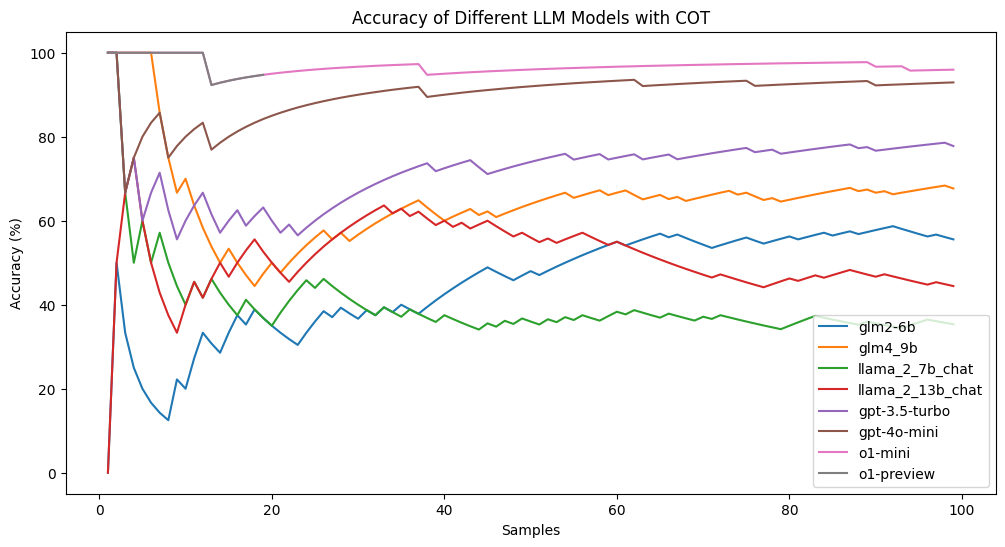

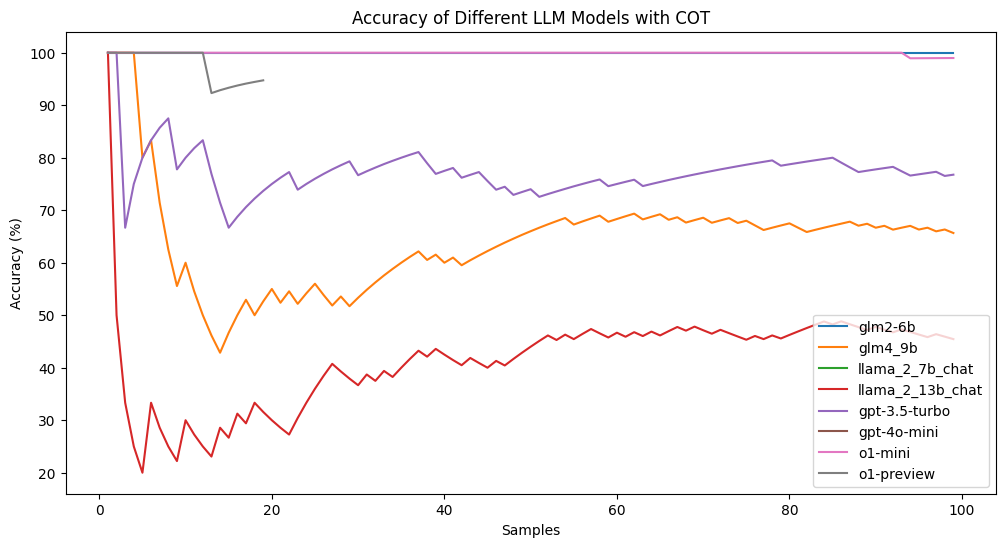

In [18]:
import re

def extract_acc(res:str):
    pattern = r'\[Evaluate\] Accuracy\[(\d+)/(\d+)\] = (\d+\.\d+)%'
    matches = re.findall(pattern, res)
    indices = []
    totals = 0
    accuracy_all = []
    if matches:
        for match in matches:
            index, total, accuracy = match
            indices.append(int(index))
            accuracy_all.append(float(accuracy))
            totals = int(total)
    return indices, accuracy_all, totals

def extract_from_file(filename:str):
    with open(filename, "r") as f:
        res = f.read()
    return extract_acc(res)


file_list_with_cot = [
    "results_glm2-6b.log",
    "results_glm4_9b.log",
    "results_llama_2_7b_chat.log",
    "results_llama_2_13b_chat.log",
    "results_gpt-3.5-turbo.log",
    "results_gpt-4o-mini.log",
    "results_o1-mini.log",
    "results_o1-preview.log"
]

labels = ["glm2-6b", "glm4_9b", "llama_2_7b_chat", "llama_2_13b_chat", "gpt-3.5-turbo", "gpt-4o-mini", "o1-mini", "o1-preview"]

file_list_no_cot = [
    "results_glm2-6b-no-cot.log",
    "results_glm4_9b-no-cot.log",
    "results_llama_2_7b_chat-no-cot.log",
    "results_llama_2_13b_chat-no-cot.log",
    "results_gpt-3.5-turbo-no-cot.log",
    "results_gpt-4o-mini-no-cot.log",
    "results_o1-mini-no-cot.log",
    "results_o1-preview-no-cot.log"
]

def extract_from_files(file_list):
    results = []
    for file in file_list:
        indices, accuracy_all, totals = extract_from_file(file)
        if indices is not None:
            results.append((indices, accuracy_all, totals))
    return results


def visualize_results(results, title:str):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    idx = 0
    for indices, accuracy_all, totals in results:
        ax.plot(indices, accuracy_all, label=f"{labels[idx]}")
        idx += 1

    ax.set_xlabel("Samples")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title(title)
    ax.legend()
    plt.show()


results_with_cot = extract_from_files(file_list_with_cot)
results_no_cot = extract_from_files(file_list_no_cot)
visualize_results(results_with_cot, "Accuracy of Different LLM Models with COT")
visualize_results(results_no_cot, "Accuracy of Different LLM Models with COT")
